In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0
noise_factor = 0.5

In [5]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

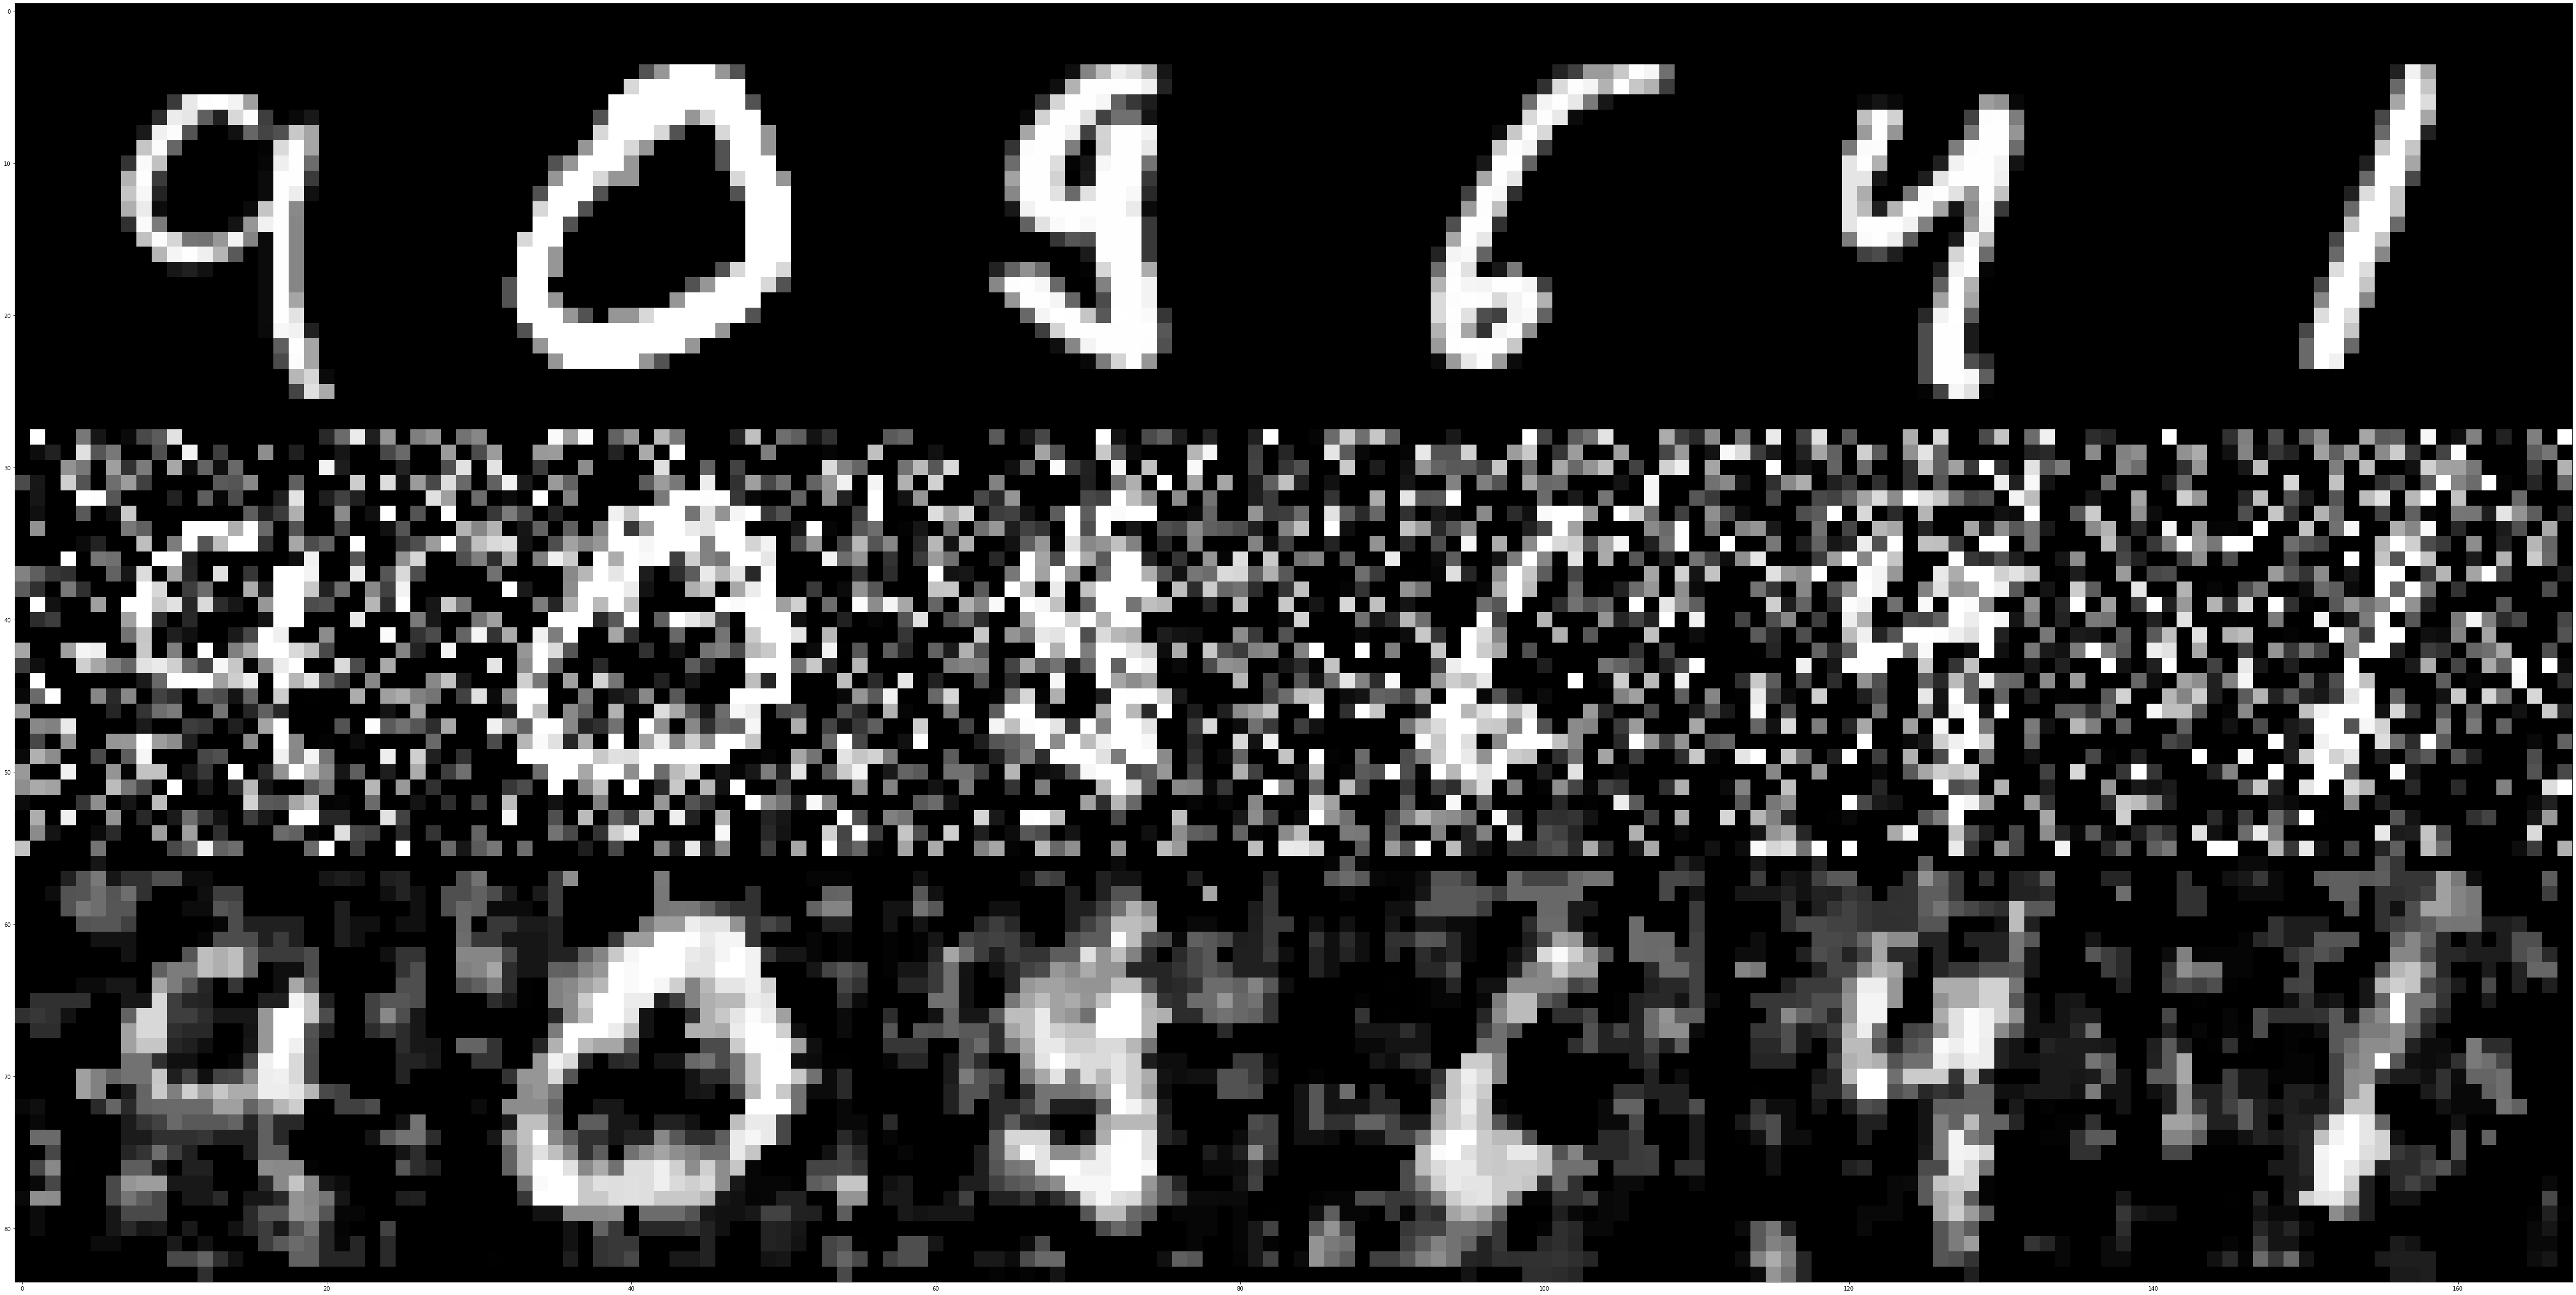

In [6]:
num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [7]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [8]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(vae, to_file='model1.png',show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=VAE_loss, experimental_run_tf_function=False)

In [11]:
vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

Epoch 1/10


TypeError: in user code:

    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:237 __call__
        self._loss_metric.update_state(
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:177 update_state_fn
        return ag_update_state(*args, **kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:363 update_state  **
        sample_weight = weights_broadcast_ops.broadcast_weights(
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/ops/weights_broadcast_ops.py:155 broadcast_weights
        values = ops.convert_to_tensor(values, name="values")
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:281 _constant_impl
        tensor_util.make_tensor_proto(
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:435 make_tensor_proto
        values = np.asarray(values)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/numpy/core/_asarray.py:83 asarray
        return array(a, dtype, copy=False, order=order)
    /home/main/anaconda3/envs/constellation/lib/python3.8/site-packages/tensorflow/python/keras/engine/keras_tensor.py:273 __array__
        raise TypeError(

    TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


In [18]:
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

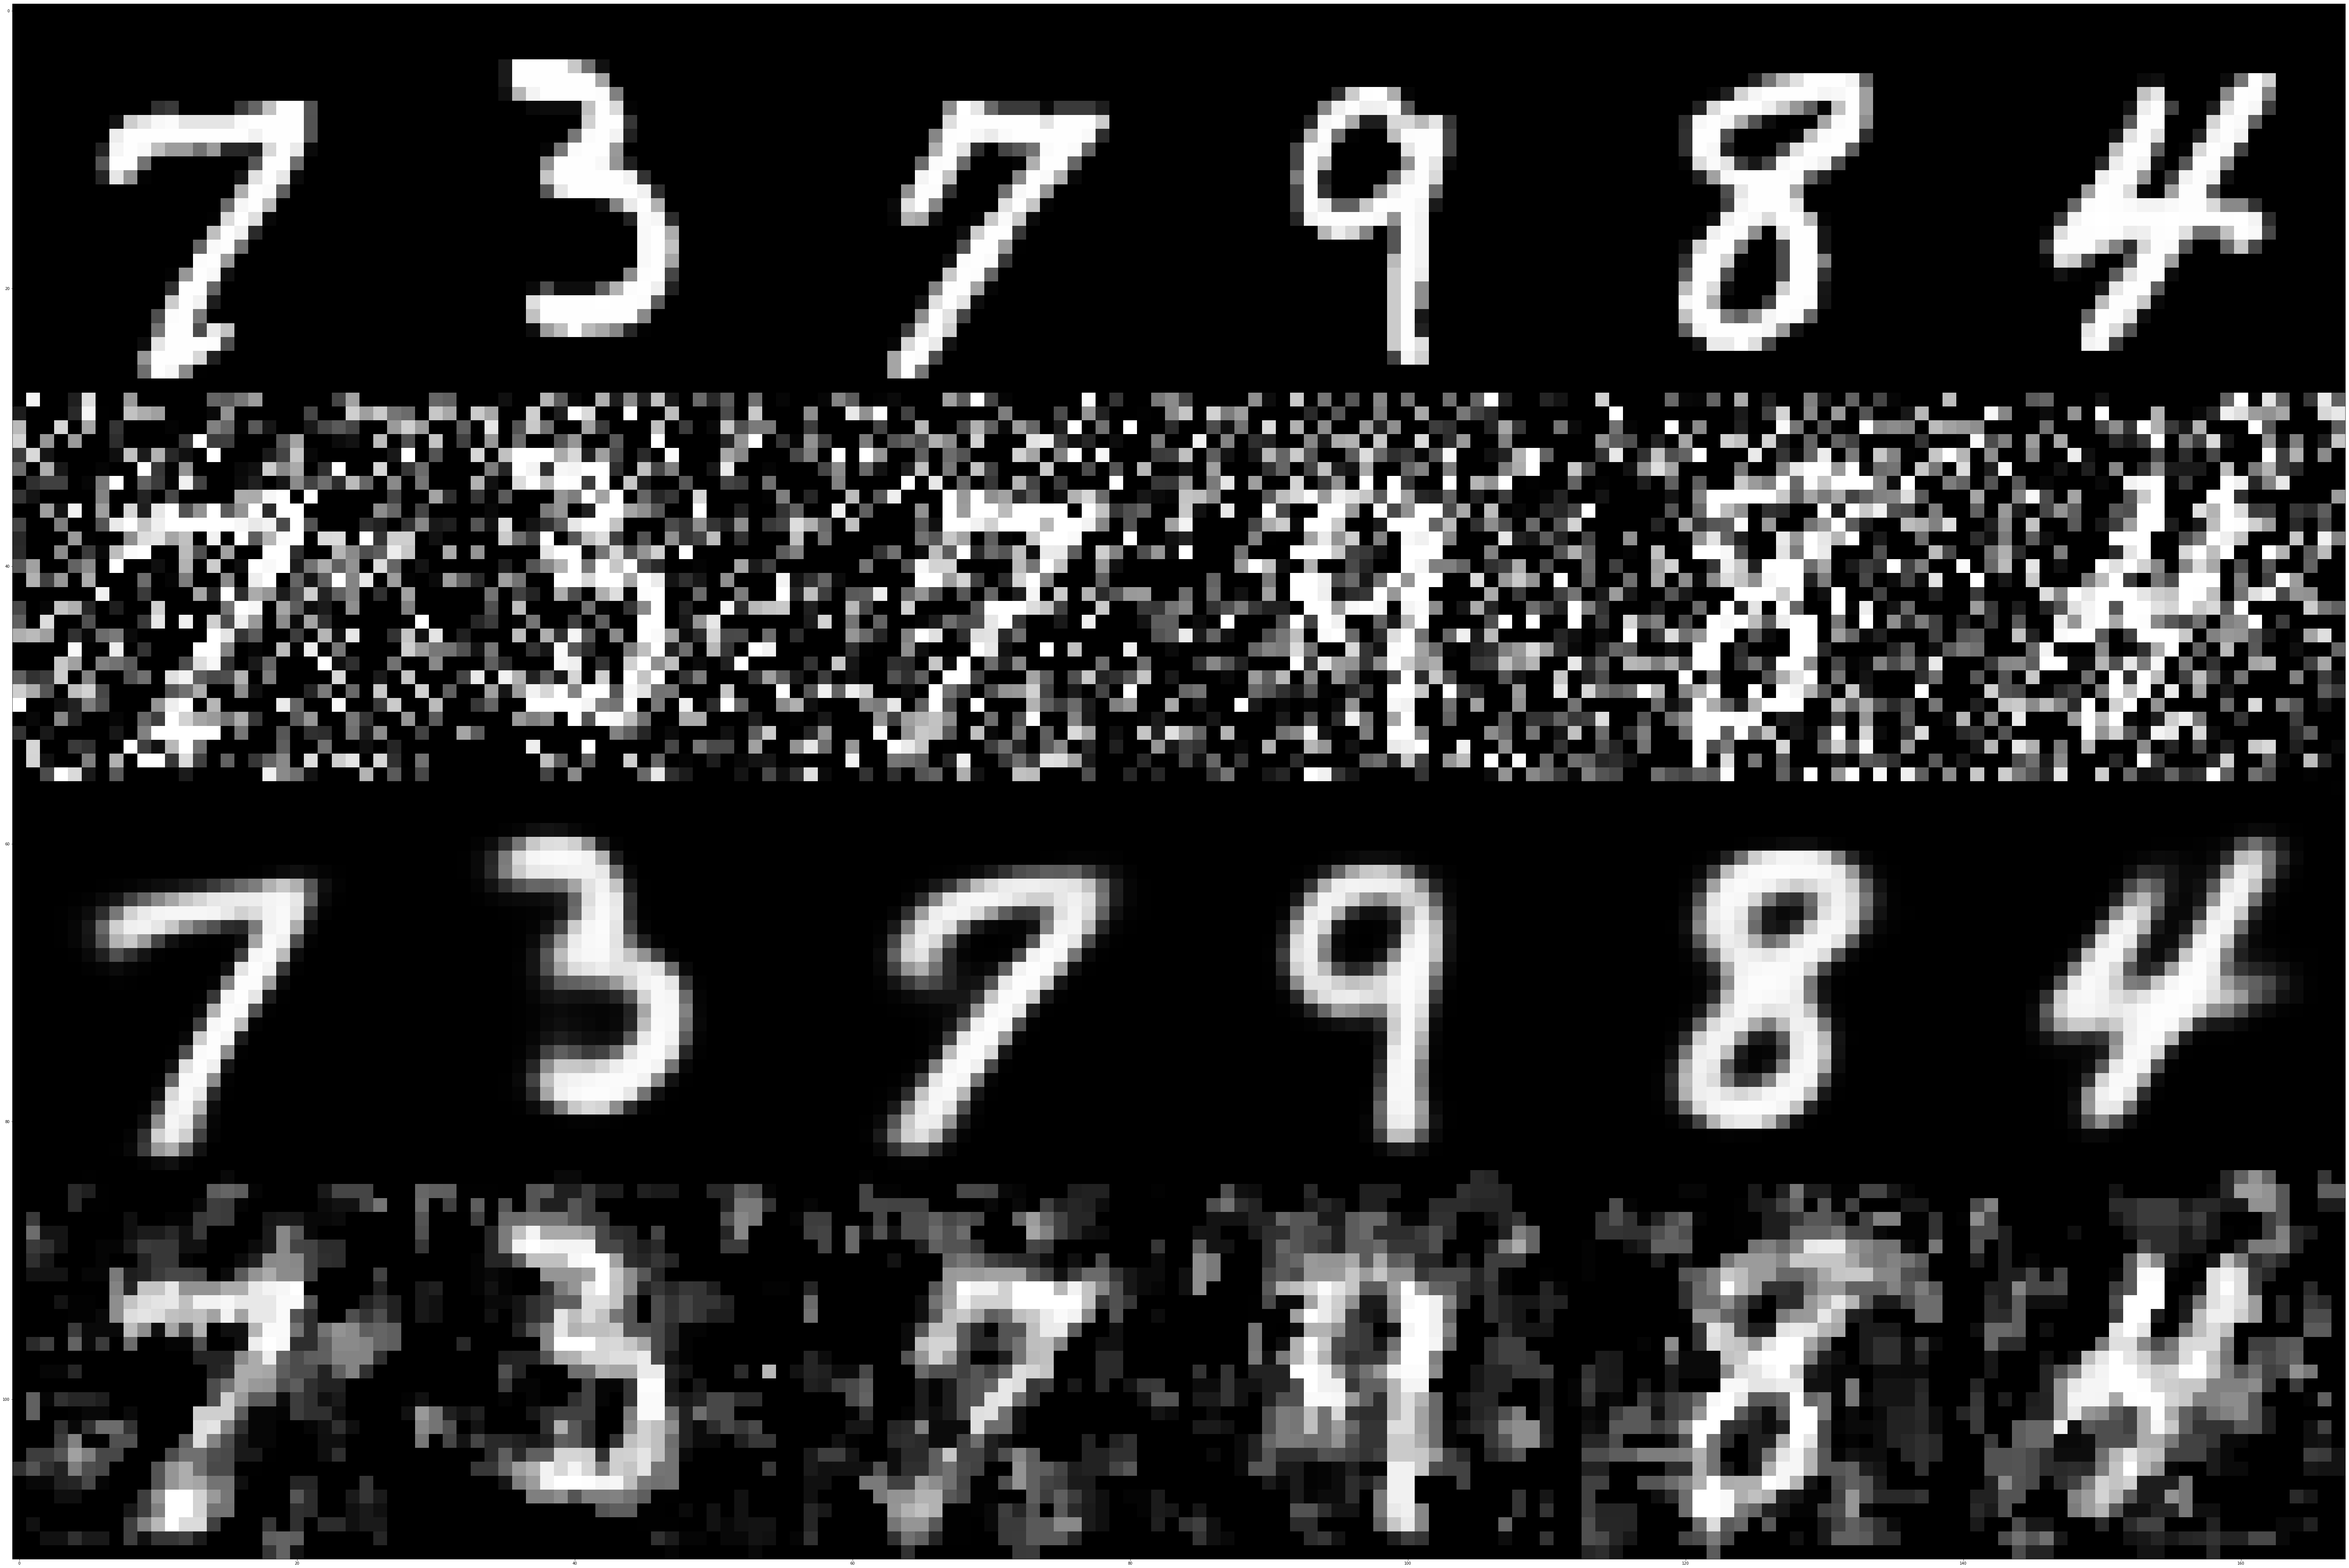

In [22]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_VAE.png')
plt.show()